In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
ds = xr.open_dataset("../../NC/compare.nc")  

In [ ]:
ds_basin = ds["basin_agri"].sel(time= "2100-01-01")+ds["basin_forest"].sel(time= "2100-01-01")+ds["basin_grassland"].sel(time= "2100-01-01")
# ds_basin = ds["basin_agri"].sel(time= "2100-01-01")+ds["basin_irrig_agri"].sel(time= "2100-01-01")
summary = {
    "min": float(ds_basin.min()),
    "max": float(ds_basin.max()),
    "mean": float(ds_basin.mean()),
    "std": float(ds_basin.std()),
    "median": float(np.nanmedian(ds_basin.values)),
    "count": int(np.isfinite(ds_basin.values).sum())
}
summary

In [ ]:
def summary_to_file(diff,f):
    max = float(diff.max())
    min = float(diff.min())
    mean = float(diff.mean())
    std = float(diff.std())
    median = float(np.nanmedian(diff.values))
    f.write(f"max: {max:.3f}\n")
    f.write(f"min: {min:.3f}\n")
    f.write(f"mean: {mean:.3f}\n")
    f.write(f"std: {std:.3f}\n")
    f.write(f"median: {median:.3f}\n\n")
    

In [ ]:
names = ["agri","grassland","forest"]

years = list(range(2010, 2101, 10))   # 2010,2020,...,2100
years.insert(0, 2005)
with open("../../OUTPUT/region-basin_diff.txt","w",encoding="utf-8") as f:
    for year in years:

        time = f"{year}-01-01"
        f.write(f"# Time:[{time}]\n---\n")
        for name in names:
            f.write(f"## Target:[{name}]\n\n")
            var_basin  = f"basin_{name}"
            var_region = f"region_{name}"

            mode_basin  = "basin"
            mode_region = "region"

            da_basin = ds[var_basin].sel(time=time)
            da_basin = da_basin.where(~np.isnan(da_basin), drop=True)

            da_region = ds[var_region].sel(time=time)
            da_region = da_region.where(~np.isnan(da_region), drop=True)

            diff = da_region - da_basin
            mask = (da_basin>0)|(da_region>0)
            diff_valid = diff.where(mask,drop=True)
            summary_to_file(diff_valid,f)



In [ ]:
import csv
import numpy as np

names = ["agri", "grassland", "forest"]
stats = ["max", "min", "mean", "std", "median"]
stats_map = {
    "max": "max",
    "min": "min",
    "mean": "mean",
    "std": "std",
    "median": "med",   # median → med
}
# 生成所有列名
columns = ["time"]
for name in names:
    short = name[0]    # 取首字母，如 "a"
    for s in stats:
        columns.append(f"{short}_{stats_map[s]}")

years = list(range(2010, 2101, 10))
years.insert(0, 2005)

# 打开 CSV 写入
with open("../../OUTPUT/region-basin_diff_summary.csv", "w", encoding="utf-8", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(columns)   # 写入标题行
    
    for year in years:
        time = f"{year}-01-01"

        # 每一行数据以列表形式存储
        row = [year]

        for name in names:
            var_basin  = f"basin_{name}"
            var_region = f"region_{name}"

            # 取当年地图
            da_basin = ds[var_basin].sel(time=time)
            da_basin = da_basin.where(~np.isnan(da_basin), drop=True)

            da_region = ds[var_region].sel(time=time)
            da_region = da_region.where(~np.isnan(da_region), drop=True)

            # 差值
            diff = da_region - da_basin

            # 有效区域mask（避免 0 稀释）
            mask = (da_basin > 0) | (da_region > 0)
            diff_valid = diff.where(mask, drop=True)

            # 计算统计量
            max_v    = float(f"{diff_valid.max().item():.3f}")
            min_v    = float(f"{diff_valid.min().item():.3f}")
            mean_v   = float(f"{diff_valid.mean().item():.3f}")
            std_v    = float(f"{diff_valid.std().item():.3f}")
            median_v = float(f"{np.nanmedian(diff_valid.values):.3f}")


            # 写入到当前行
            row.extend([max_v, min_v, mean_v, std_v, median_v])

        # 每年写入一行
        writer.writerow(row)



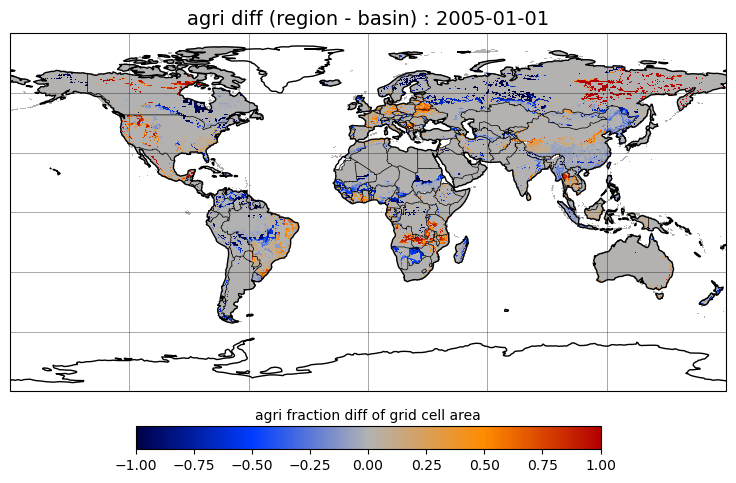

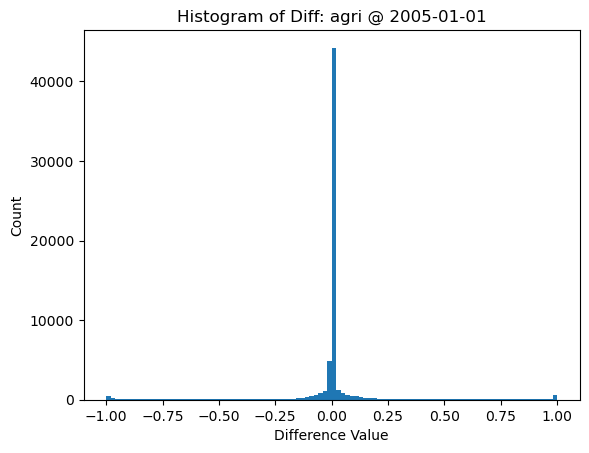

In [50]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

time = "2005"
task = "agri"
year =f"{time}-01-01"

var_basin  = f"basin_{name}"
var_region = f"region_{name}"

# 取当年地图
da_basin = ds[var_basin].sel(time=year)
#da_basin = da_basin.where(~np.isnan(da_basin))

da_region = ds[var_region].sel(time=year)
#da_region = da_region.where(~np.isnan(da_region))

# 差值
diff = da_region - da_basin
diff_v = diff
# 有效区域mask（避免 0 稀释）
# mask = (da_basin > 0) | (da_region > 0)
# diff_v = diff.where(mask)
# diff_v = diff_v.squeeze().values

lon = ds.lon
lat = ds.lat
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

diff_colors = [
    (0.0,   (0/255, 0/255, 70/255)),    # very dark blue
    (0.25,  (0/255, 60/255, 255/255)),  # saturated blue
    (0.5,   (0.7, 0.7, 0.7)),           # darker gray
    (0.75,  (255/255, 140/255, 0/255)), # strong orange
    (1.0,   (180/255, 0/255, 0/255))    # dark red
]

panoply_act_diff = LinearSegmentedColormap.from_list("panoply_act_diff", diff_colors)
im = ax.pcolormesh(
lon,lat,diff_v,
transform=ccrs.PlateCarree(),   # 数据仍然是lat/lon坐标
cmap=panoply_act_diff,
vmin=-1,vmax=1)

ax.coastlines()
ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.5)
gl = ax.gridlines(draw_labels=False, linewidth=0.4, color='black', alpha=0.6)

cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.075, shrink=0.5)
cbar.set_label(f"{task} fraction diff of grid cell area")
cbar.ax.xaxis.set_label_position('top')

plt.title(f"{task} diff ({mode_region} - {mode_basin}) : {year}", fontsize=14)
plt.show()

plt.hist(diff_v.values.flatten(), bins=100)
plt.title(f"Histogram of Diff: {task} @ {year}")
plt.xlabel("Difference Value")
plt.ylabel("Count")
plt.show()
